# Validation set analysis

In this file loudness is analyzed for the original validation data set (n=4982). 

Loudness is analyzed by calculating the RMS values for each audio file using a moving window of 2048 samples (about 46 ms). 
Then the max rms value per audio file is selected and transformed to decibels using the following formula:

$$
\text{Let } \text{inp} = \max(\epsilon, \text{RMS Peak})
$$

$$
\text{Then, dB} = 20 \log_{10}\left(\frac{\text{inp}}{\text{ref}}\right)
$$

Where $\epsilon$ is set to 1e-10 to avoid negative infinity values. And the reference value $\text{ref}$ is set to 1.0


In [24]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from nexa_coding_interpreter.metadata import Metadata
from pathlib import Path
from nexa_py_sentimotion_mapper.sentimotion_mapper import Mapper

import warnings
warnings.filterwarnings('ignore')

In [2]:
def detect_rms(audio_file, threshold=0.01, frame_length=2048, hop_length=512):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Calculate the RMS energy of the audio using a moving window
    ret_rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    return ret_rms

In [3]:
def rms_to_db(input_rms, ref=1.0, epsilon=1e-10):
    inp = np.maximum(epsilon, input_rms)

    # Convert RMS values to decibels
    return 20 * np.log10(inp/ref)

In [4]:
path = '../data/original_validation_experiment/*.mp4'
glob_audio_files = glob(path)

In [31]:
rms_dict = {}
rms_peak_dict = {}
rms_peak_db_dict = {}

for idx, af in enumerate(glob_audio_files):
    print(f'Processing {af} {idx}/{len(glob_audio_files)}')

    filename = os.path.basename(af)
    rms = detect_rms(af)
    rms_peak = np.max(rms)
    rms_peak_db = rms_to_db(rms_peak)

    rms_dict[filename] = rms
    rms_peak_dict[filename] = rms_peak
    rms_peak_db_dict[filename] = rms_peak_db

In [6]:
# Assuming rms_peak_db_dict contains your peak dB levels for each file
peak_levels_db = list(rms_peak_db_dict.values())

## Descriptives

In [7]:
# Calculate the mean and standard deviation
mean_db = np.mean(peak_levels_db)
std_dev_db = np.std(peak_levels_db)

print(f"Mean Peak Level (dB): {mean_db:.2f}")
print(f"Standard Deviation of Peak Levels (dB): {std_dev_db:.2f}")

Mean Peak Level (dB): -54.64
Standard Deviation of Peak Levels (dB): 11.64


In [16]:
# Calculate various percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(peak_levels_db, percentiles)

# Display the percentiles
print("Percentiles for Peak Levels (dB):")
for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value:.2f} dB")

Percentiles for Peak Levels (dB):
5th percentile: -73.68 dB
10th percentile: -68.73 dB
25th percentile: -61.36 dB
50th percentile: -53.94 dB
75th percentile: -47.40 dB
90th percentile: -40.96 dB
95th percentile: -37.38 dB


## Histogram

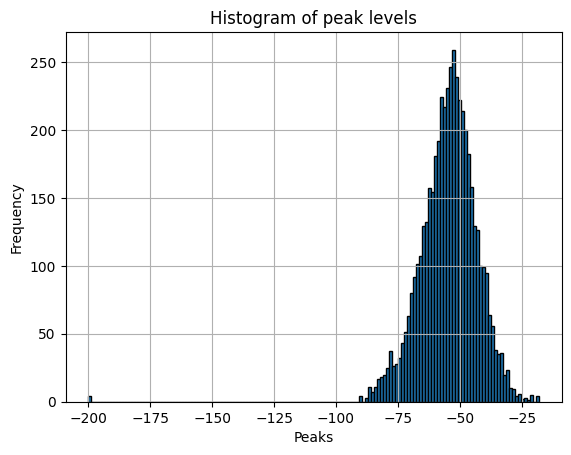

In [10]:
plt.hist(rms_peak_db_dict.values(), bins=150, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Peaks')
plt.ylabel('Frequency')
plt.title('Histogram of peak levels')
plt.grid(True)
plt.show()

## Boxplots

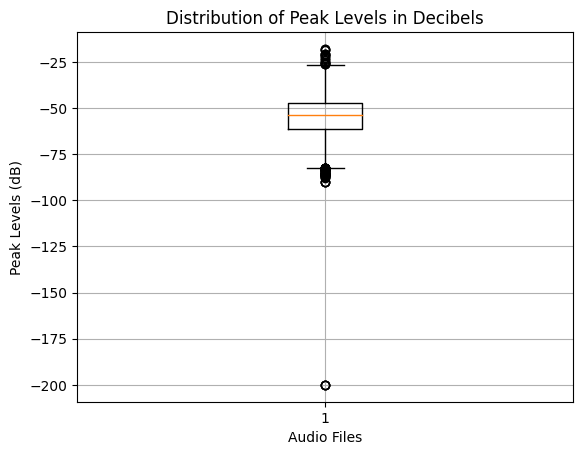

In [11]:
plt.boxplot(rms_peak_db_dict.values())
plt.xlabel('Audio Files')
plt.ylabel('Peak Levels (dB)')
plt.title('Distribution of Peak Levels in Decibels')
plt.grid(True)
plt.show()

### Boxplot without outliers (silent files with peak level = -200)

In [14]:
# Filter out entries with peak levels at or below -100 dB
filtered_peak_db_dict = {k: v for k, v in rms_peak_db_dict.items() if v > -100}

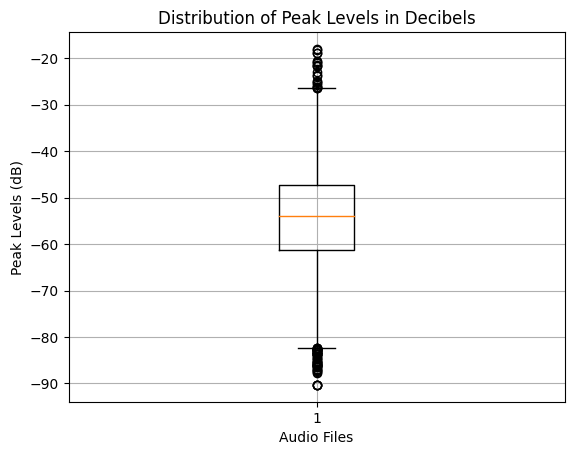

In [15]:
plt.boxplot(filtered_peak_db_dict.values())
plt.xlabel('Audio Files')
plt.ylabel('Peak Levels (dB)')
plt.title('Distribution of Peak Levels in Decibels')
plt.grid(True)
plt.show()

### Characteristics of relatively silent files

Based on the plots in this section we can conclude that the distribution of emotions in the most silent 10:th percentile of the data the distribution of emotions is pretty even, while the distributions of modes leans heavily towards vocalization

In [22]:
sorted_tuples = sorted(rms_peak_db_dict.items(), key=lambda item: item[1])
sorted_dict = dict(sorted_tuples)

# Assuming peak_levels_db contains all your peak dB levels
peak_levels_db = list(sorted_dict.values())

# Calculate the 10th percentile value
percentile_10_value = np.percentile(peak_levels_db, 10)

# print(f"Files at or below the 10th percentile (Peak Level: {percentile_10_value:.2f} dB):")

percentile_10_files = []

# Iterate through the sorted dictionary
for filename, peak_db in sorted_dict.items():
    if peak_db <= percentile_10_value:
        percentile_10_files.append(filename)
        # print(f"{filename}: {peak_db:.2f} dB")
    else:
        # Since the dictionary is sorted, we can break once we pass the 10th percentile
        break

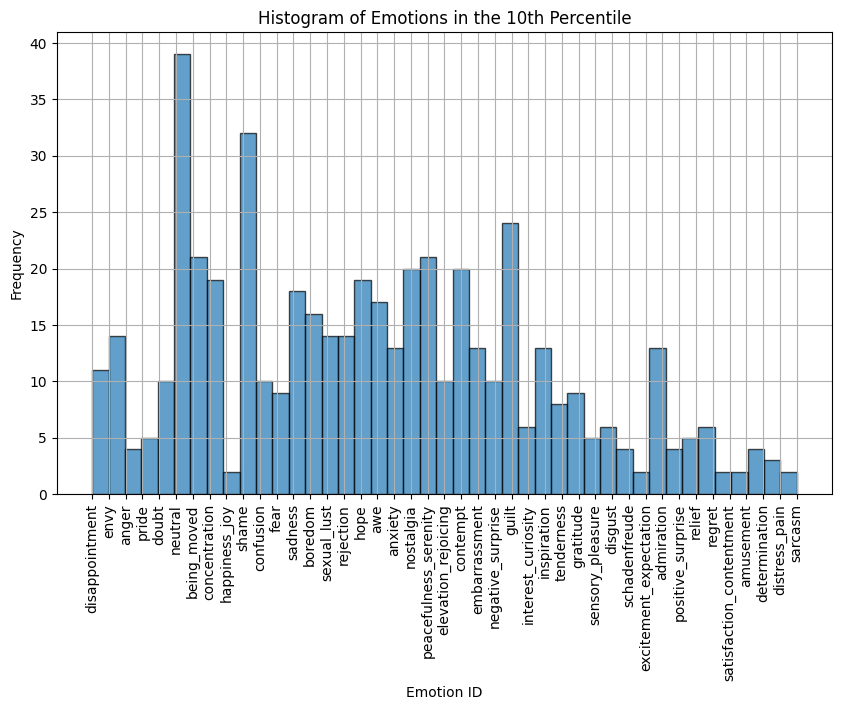

In [28]:
emotions = []
modes = []

for filename in percentile_10_files:
    filename_no_ext = Path(filename).stem
    meta = Metadata(filename_no_ext)
    emotion = Mapper.get_emotion_from_id(meta.emotion_1_id)
    
    emotions.append(emotion)
    modes.append(meta.mode)
    
plt.figure(figsize=(10, 6))
plt.hist(emotions, bins=len(set(emotions)), edgecolor='black', alpha=0.7)
plt.xlabel('Emotion ID')
plt.ylabel('Frequency')
plt.title('Histogram of Emotions in the 10th Percentile')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.grid(True)
plt.show()

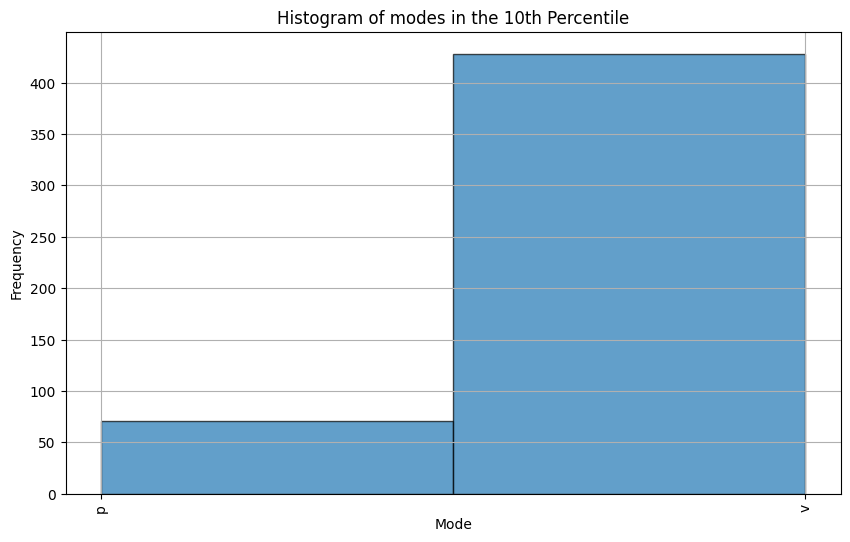

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(modes, bins=len(set(modes)), edgecolor='black', alpha=0.7)
plt.xlabel('Mode')
plt.ylabel('Frequency')
plt.title('Histogram of modes in the 10th Percentile')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.grid(True)
plt.show()

### File inspection

Inspection files ordered by peak levels, only files with mode = prosody included.

In [13]:
for key, val in sorted_dict.items():
    filename_no_ext = Path(key).stem
    meta = Metadata(filename_no_ext)

    if meta.mode == "p":
        print(f'filename: {filename_no_ext}, rms_peak_db: {val}')

filename: A207_disa_p_2, rms_peak_db: -200.0
filename: A207_env_p_3, rms_peak_db: -200.0
filename: A207_pri_p_2, rms_peak_db: -200.0
filename: A303_dou_p_2, rms_peak_db: -90.30899869919436
filename: A200_neu_sit4_p, rms_peak_db: -90.30899869919436
filename: A426_anx_p_3, rms_peak_db: -83.75133941359263
filename: A405_sex_p_3, rms_peak_db: -80.6181134372207
filename: A435_ten_p_3, rms_peak_db: -80.51976049526306
filename: A426_bor_p_3, rms_peak_db: -79.70645725640794
filename: A435_ten_p_2, rms_peak_db: -78.13472383836725
filename: A405_bor_p_3, rms_peak_db: -77.91798155908681
filename: A405_hop_p_3, rms_peak_db: -77.8453831312882
filename: A435_emb_p_2, rms_peak_db: -77.49906406292494
filename: A55_pea_p_3, rms_peak_db: -76.11264468626685
filename: A435_gui_p_2, rms_peak_db: -75.82459699568633
filename: A435_neg_sur_p_2, rms_peak_db: -75.77309100144683
filename: A435_sha_p_2, rms_peak_db: -75.28544020532411
filename: A405_hop_p_2, rms_peak_db: -74.82514271040684
filename: A435_reg_p_2,